# Xarray-spatial
### User Guide: Pathfinding
-----

[A* Pathfinding](#A*)

-----------


#### Let's use datashader to render our images...

In [1]:
import numpy as np
import datashader as ds
from datashader.transfer_functions import shade
from datashader.transfer_functions import stack
from datashader.transfer_functions import dynspread
from datashader.transfer_functions import set_background
from datashader.colors import Elevation

import xrspatial

## A*

A* is an informed search algorithm, or a best-first search, meaning that it is formulated in terms of weighted graphs: starting from a specific starting node of a graph, it aims to find a path to the given goal node having the smallest cost (min distance travelled, shortest time, ...). 

The `xrspatial.a_star_search` function calculate the shortest path in pixel space from a start location to a goal location  through a given aggregate surface graph. The graph should be a line raster which contains crossable and non-crossable (a.k.a walls or barrieres) values. Note that both start and goal are in (lon, lat), or (x, y) coordinate space and must be within the graph. The `xrspatial.a_star_search` provides 2 separate options, `snap_start` and `snap_goal`, which can be set true to snap locations to the nearest valid value before beginning pathfinding. It also provides `connectivity` option to indicate neighborhood structure. This value can be set to either 4 or 8 that represents for 4-connectivity and 8-connectivity accordingly.

Let's generate some fake line raster and find shortest path with A*.

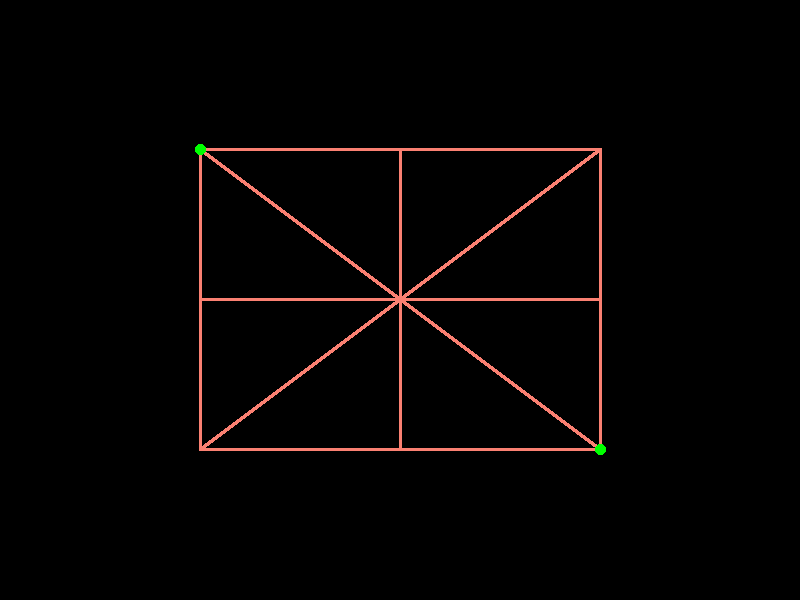

In [2]:
from xrspatial import a_star_search
import pandas as pd

# define range of x and y
xrange = (0, 4)
yrange = (0, 4)

# create line raster
ys = [1, 1, 3, 3, 1, 1, np.nan, 1, 3, np.nan, 1, 3, np.nan, 1, 3, np.nan, 2, 2]
xs = [1, 3, 3, 1, 1, 3, np.nan, 1, 3, np.nan, 3, 1, np.nan, 2, 2, np.nan, 1, 3]
line_df = pd.DataFrame(dict(x=xs, y=ys))

W = 800
H = 600
cvs = ds.Canvas(plot_width=W, plot_height=H,
                x_range=xrange, y_range=yrange)
line_agg = cvs.line(line_df, x='x', y='y').astype(int)
line_shaded = dynspread(shade(line_agg, cmap=['salmon']))

# pick up 2 random locations
start = (1, 3)
goal = (3, 1)

location_df = pd.DataFrame({'x': [start[0], goal[0]], 'y': [start[1], goal[1]]})
location_agg = cvs.points(location_df, 'x', 'y')
location_shaded = dynspread(shade(location_agg, cmap=['lime']), threshold=1, max_px=5)

set_background(stack(line_shaded, location_shaded), 'black')

### 8-connectivity

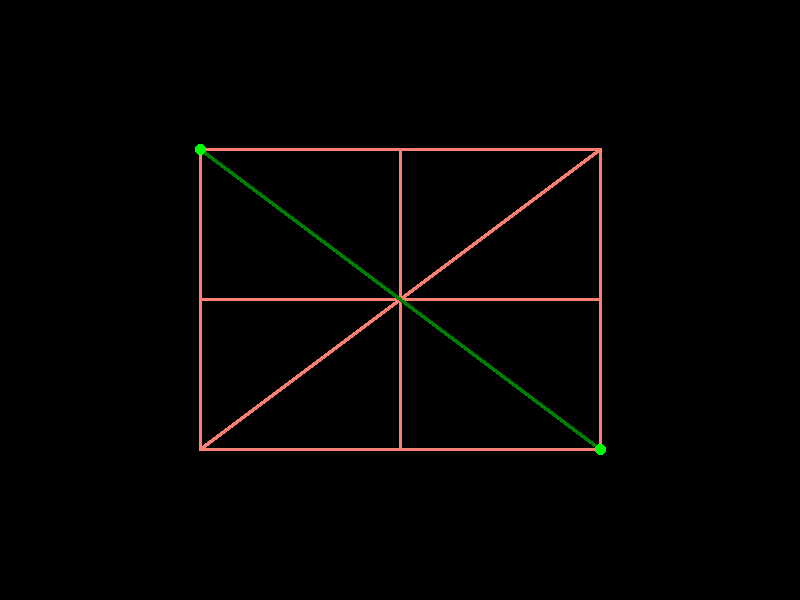

In [3]:
# find the path from start to goal, 
# barriers are uncrossable cells. In this case, they are cells with a value of 0

path_agg_8_connectivity = a_star_search(line_agg, start, goal, barriers=[0], snap_start=True, snap_goal=True)

path_shaded = dynspread(shade(path_agg_8_connectivity, cmap=['green']))
set_background(stack(line_shaded, path_shaded, location_shaded), 'black')

### 4-connectivity

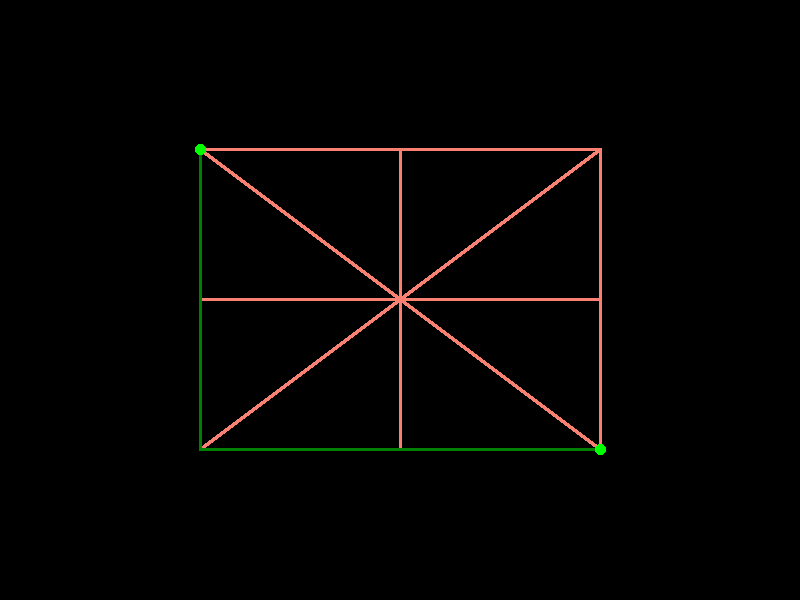

In [4]:
# find the path from start to goal, 
# barriers are uncrossable cells. In this case, they are cells with a value of 0

path_agg_4_connectivity = a_star_search(line_agg, start, goal, barriers=[0],
                                        snap_start=True, snap_goal=True, connectivity=4)

path_shaded = dynspread(shade(path_agg_4_connectivity, cmap=['green']))
set_background(stack(line_shaded, path_shaded, location_shaded), 'black')

### An example of the City of Austin road network

The road network used in this example notebook can be downloaded from:

https://data.austintexas.gov/Locations-and-Maps/Street-Centerline/m5w3-uea6

In [5]:
import geopandas

# load data
streets = geopandas.read_file('zip://./../data/Street_Centerline.zip')
streets = streets.to_crs({'init': 'epsg:4326'})

xs = []
ys = []
for s in streets.geometry.values:
    try:
        coords = s.coords.xy
        xs += coords[0].tolist()
        ys += coords[1].tolist()
        
        xs.append(np.nan)
        ys.append(np.nan)
    except:
        continue
        
street_df = pd.DataFrame(dict(x=xs, y=ys))

C:\Users\mdo\Anaconda3\envs\xarray-spatial\lib\site-packages\pyproj\crs.py:122: DeprecationWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  DeprecationWarning,


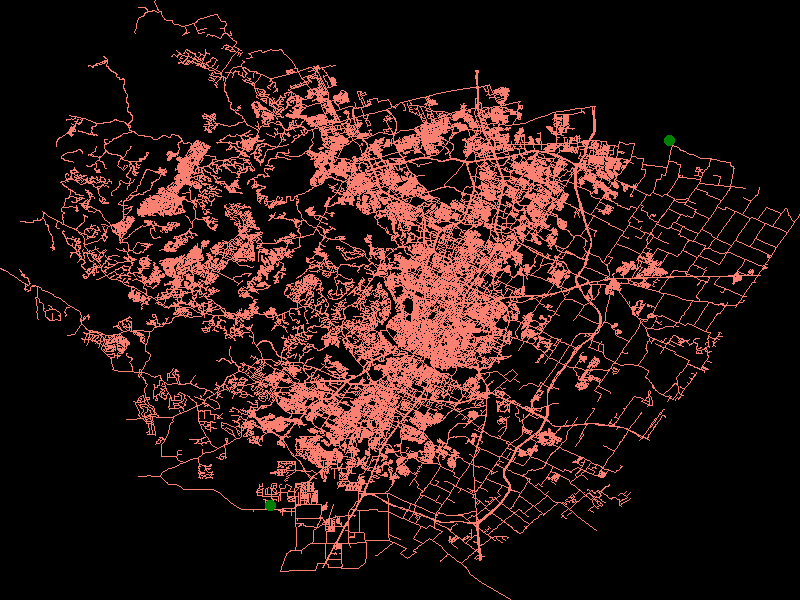

In [6]:
H, W = 600, 800

xrange = (-98.170507844129, -97.36979731249)
yrange = (29.995950090365, 30.654731756587)

cvs = ds.Canvas(plot_width=W, plot_height=H,
                x_range=xrange, y_range=yrange)

street_agg = cvs.line(street_df, x='x', y='y').astype(int)
street_shaded = dynspread(shade(street_agg, cmap=['salmon']))

# Pick two locations
start = (-97.9, 30.1)
goal  = (-97.5, 30.5)

location_df = pd.DataFrame({'x': [start[0], goal[0]], 'y': [start[1], goal[1]]})
location_agg = cvs.points(location_df, 'x', 'y')
location_shaded = dynspread(shade(location_agg, cmap=['green']), threshold=1, max_px=5)

set_background(stack(street_shaded, location_shaded), 'black')

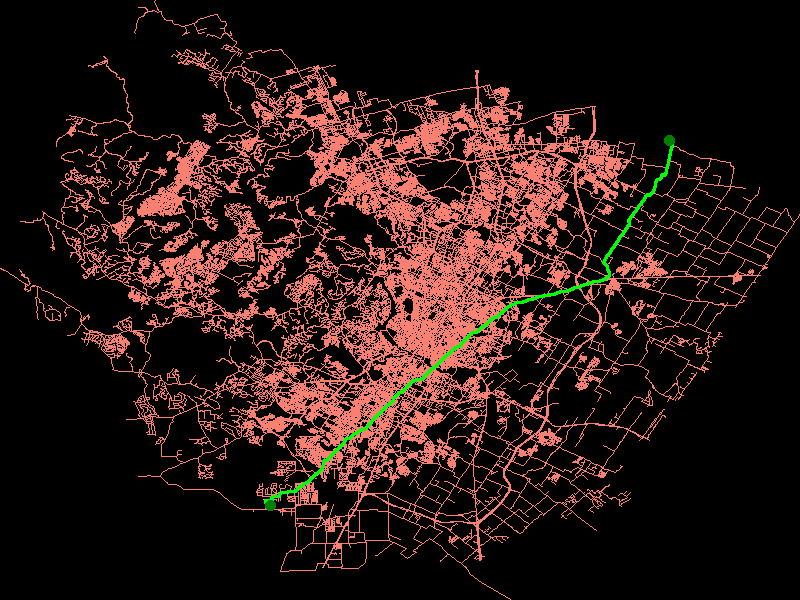

In [7]:
# find the path from start to goal, 
# barriers are uncrossable cells. In this case, they are cells with a value of 0
# use 8-connectivity as defaulted

path_agg = a_star_search(street_agg, start, goal, barriers=[0], snap_start=True, snap_goal=True)

path_shaded = dynspread(shade(path_agg, cmap=['lime']))
set_background(stack(street_shaded, path_shaded, location_shaded), 'black')




### References

- A* search algorithm: https://en.wikipedia.org/wiki/A*_search_algorithm